In [1]:
import pybamm
pybamm.settings.heaviside_smoothing = 10
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
#notify=Audio(url = url, autoplay = True)
notify=Audio(filename = "/home/drmrfc/Downloads/echoed-ding-459.mp3", autoplay = True)
########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

# Base Run to compare against (no concentration effects)

In [13]:
S8_initial_g = 2.6565990721396795
S6_initial_g = 0.03308746536461487
S4_initial_g = 0.013008078277994115
S2_initial_g = 2.8449317677625998e-08
S1_initial_g = 4.404388467562549e-12
Sp_initial_g = 2.6636551382083317e-06

# the total active material mass
m_s = S8_initial_g + S6_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S6_initial_frac = S6_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168*1.2

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt*3
S6_initial_hunt = S6_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S6_initial_hunt,
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

In [18]:
current = 2*0.0211
hours = 15
time_in_seconds = 5000#hours*3600
model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": discharge_initial_data[1],
        "Initial Condition for S6 ion [g]": discharge_initial_data[2],
        "Initial Condition for S4 ion [g]": discharge_initial_data[3],
        "Initial Condition for S2 ion [g]": discharge_initial_data[4],
        "Initial Condition for S ion [g]": discharge_initial_data[5],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[6],
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": 50,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 1.8,
        "Standard Potential L [V]": 1.95,
        "Standard Potential M [V]": 1.975,
        "Standard Potential H [V]": 2.38,
        "gamma": 25000,
        "kappa" : 15,
        #"S saturation mass [g]": 1e-6,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)


SyntaxError: invalid syntax (<ipython-input-18-fa274834c448>, line 23)

In [33]:
def run_sim(params_dict, total_time_in_seconds):
    model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
    params = model.default_parameter_values
    params.update(params_dict)
    
    # initializing simulation 
    sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        #max_step_decrease_count = 15
        ),
    )
    time_in_seconds = 5000
    sim.solve(np.linspace(0, time_in_seconds, 5000))
    
    # remaining simulation 
    # step up to tf in steps of ts
    tf = total_time_in_seconds
    ts = 100
    max_count = 10
    count = 0
    t = sim.solution.t[-1]
    while t < tf:
        try:
            sim.step(ts,npts=100)#int(ts/10))
        except:
            count = count + 1
            ts = ts / 2 
        t = sim.solution.t[-1]
        if count > max_count:
            break
        if min(sim.solution['Terminal voltage [V]'].entries) < sim.parameter_values['Lower voltage cut-off [V]']:
            break
    return sim

In [42]:
current = 2*0.0211
hours = 5.5
total_time_in_seconds = 12000 #hours*3600
params_dict =     {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": discharge_initial_data[1],
        "Initial Condition for S6 ion [g]": discharge_initial_data[2],
        "Initial Condition for S4 ion [g]": discharge_initial_data[3],
        "Initial Condition for S2 ion [g]": discharge_initial_data[4],
        "Initial Condition for S ion [g]": discharge_initial_data[5],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[6],
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": 50,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 1.8,
        "Standard Potential L [V]": 1.95,
        "Standard Potential M [V]": 1.975,
        "Standard Potential H [V]": 2.38,
        "gamma": 250,
        "kappa" : 15,
        #"S saturation mass [g]": 1e-6,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
sim = run_sim(params_dict, total_time_in_seconds)
notify

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

(1.4, 2.5)

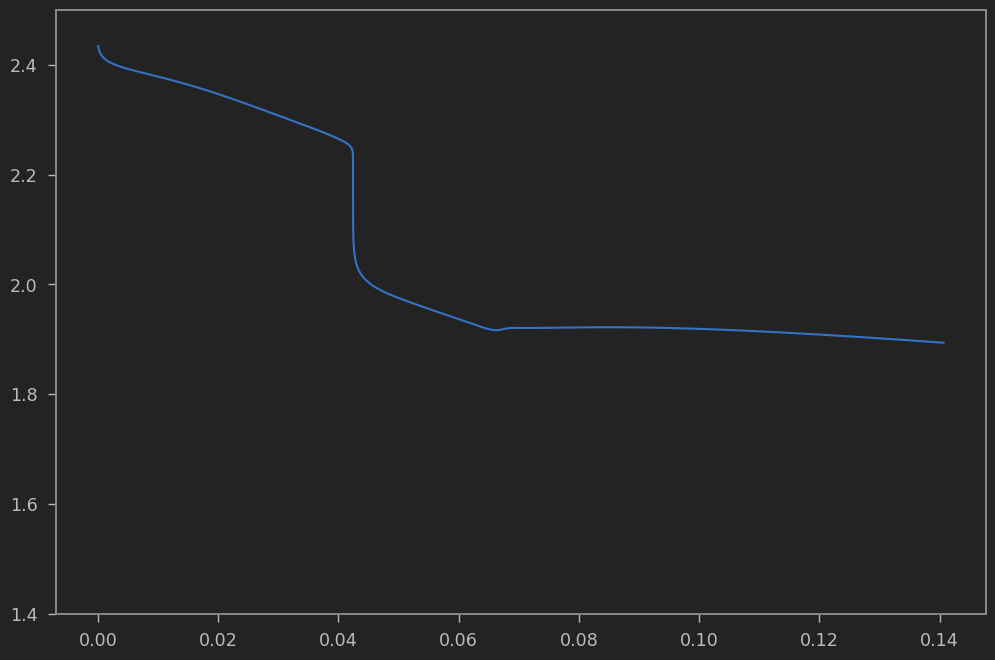

In [43]:
plt.plot(sim.solution["Discharge capacity [A.h]"].entries,sim.solution["Terminal voltage [V]"].entries)
plt.ylim([1.4,2.5])

1.8

In [3]:
current = 2*0.0211
hours = 15
time_in_seconds = 5000#hours*3600
model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": discharge_initial_data[1],
        "Initial Condition for S6 ion [g]": discharge_initial_data[2],
        "Initial Condition for S4 ion [g]": discharge_initial_data[3],
        "Initial Condition for S2 ion [g]": discharge_initial_data[4],
        "Initial Condition for S ion [g]": discharge_initial_data[5],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[6],
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": 50,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 1.8,
        "Standard Potential L [V]": 1.95,
        "Standard Potential M [V]": 1.975,
        "Standard Potential H [V]": 2.38,
        "gamma": 0,#25000,
        "kappa" : 0#,15,
        #"S saturation mass [g]": 1e-6,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)


In [4]:
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        max_step_decrease_count = 15
    ),
)
time_in_seconds = 5000
sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds/10)))
notify

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

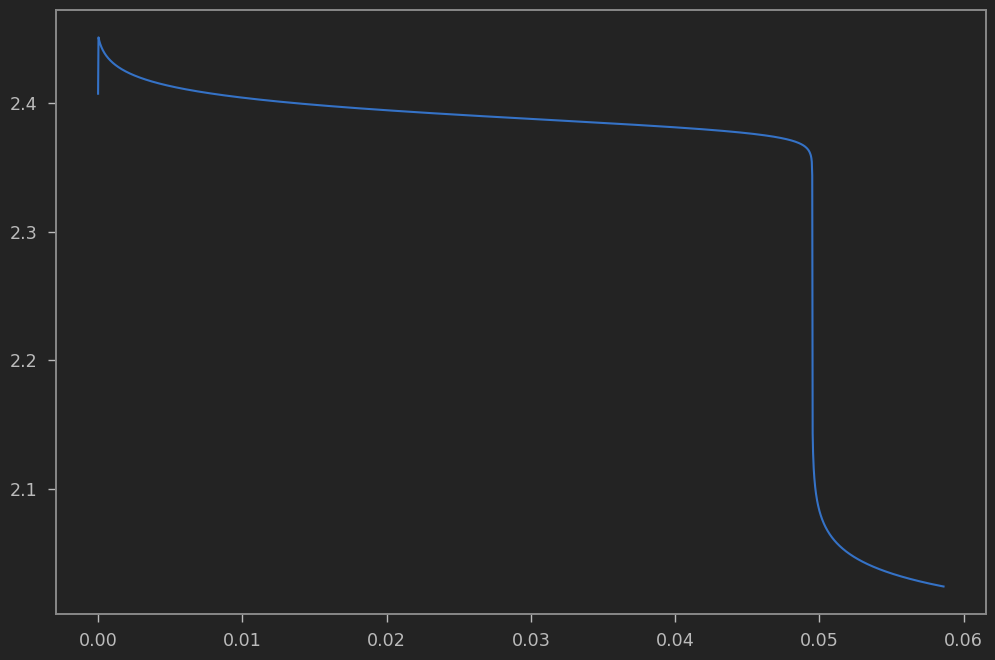

In [5]:
voltage = sim.solution['Terminal voltage [V]'].entries
x = np.where(voltage <= 2.4)
loc = x[0][0]
S8_initial = sim.solution['S8 [g]'].entries[loc]
S6_initial = sim.solution['S6 [g]'].entries[loc]
S4_initial = sim.solution['S4 [g]'].entries[loc]
S2_initial = sim.solution['S2 [g]'].entries[loc]
S_initial = sim.solution['S [g]'].entries[loc]
Sp_initial = sim.solution["Precipitated Sulfur [g]"].entries[loc]
V_initial = sim.solution['Terminal voltage [V]'].entries[loc]
plt.plot(sim.solution["Discharge capacity [A.h]"].entries,voltage)

In [6]:
model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": S8_initial,#*1.1,
        "Initial Condition for S6 ion [g]": S6_initial,#*0.00025,
        "Initial Condition for S4 ion [g]": S4_initial,#*0.6,
        "Initial Condition for S2 ion [g]": S2_initial,#*0.05,
        "Initial Condition for S ion [g]": S_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        #"Precipitation rate [s-1]": 50,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 1.8,
        "Standard Potential L [V]": 1.95,
        "Standard Potential M [V]": 1.975,
        "Standard Potential H [V]": 2.38,
        "gamma": 0,#200,
        "kappa" : 0,#30,
        #"S saturation mass [g]": 1e-6,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)

In [17]:
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        max_step_decrease_count = 15
    ),
)
time_in_seconds = 13000
sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds/10)))
notify

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

KeyboardInterrupt: 

In [ ]:
voltage = sim.solution['Terminal voltage [V]'].entries 
capacity = sim.solution["Discharge capacity [A.h]"].entries
plt.plot(capacity, voltage)
plt.ylim([1.4,2.5])
plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Chemistry 5 with no Concentration Effeccts')
#plt.legend(['Sigmoid Function', 'Experiment'])
plt.grid(True)

In [89]:
def run_partial_sim(interval, current, initial_conditions):
    
    S8_initial, S6_initial, S4_initial, S2_initial, S_initial, Sp_initial, V_initial = initial_conditions
    
    # initialize model
    model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
    params = model.default_parameter_values
    params.update(
        {
            "Current function [A]": current,
            "Initial Condition for S8 ion [g]": S8_initial,#*1.1,
            "Initial Condition for S6 ion [g]": S6_initial,#*0.00025,
            "Initial Condition for S4 ion [g]": S4_initial,#*0.6,
            "Initial Condition for S2 ion [g]": S2_initial,#*0.05,
            "Initial Condition for S ion [g]": S_initial,
            "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
            "Initial Condition for Terminal Voltage [V]": V_initial,
            #"Precipitation rate [s-1]": 50,
            "Shuttle rate coefficient during discharge [s-1]": 0.0002,
            "Lower voltage cut-off [V]": 1.8,
            "Standard Potential L [V]": 1.95,
            "Standard Potential M [V]": 1.975,
            "Standard Potential H [V]": 2.38,
            "gamma": 0,#200,
            "kappa" : 0,#30,
            #"S saturation mass [g]": 1e-6,
            #"Electrolyte volume per cell [L]": 0.0114*.25
        }
    )
    
    # run simulation 
    sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        #max_step_decrease_count = 15
            ),
        )
    sim.solve(np.linspace(0, interval, 100))
    
    return sim

def run_full_sim(total_time_in_seconds, current, initial_conditions):
    interval = 1000
    sim_data = []
    total_sim_time = 0
    
    while total_sim_time < total_time_in_seconds:
        print('\n\n\n\n')
        print(total_sim_time)
        print('\n\n\n\n')
        try:
            
            sim = run_partial_sim(interval, current, initial_conditions)
            sim_data.append(sim)
            initial_conditions = (sim.solution["S8 [g]"].entries[-1],
                sim.solution["S6 [g]"].entries[-1],
                sim.solution["S4 [g]"].entries[-1],
                sim.solution["S2 [g]"].entries[-1],
                sim.solution["S [g]"].entries[-1],
                sim.solution["Precipitated Sulfur [g]"].entries[-1],
                sim.solution["Terminal voltage [V]"].entries[-1])
            total_sim_time += interval
        except:
            if interval > 1:
                interval /= 2
            else:
                break
    return sim_data

def plot_full_sim(sim_data, x_var, y_var):
    x_shift = 0
    for sim in sim_data:
        plt.plot(sim.solution[x_var].entries + x_shift, sim.solution[y_var].entries, color = 'blue')
        x_shift += sim.solution[x_var].entries[-1]
    plt.xlabel(x_var)
    plt.ylabel(y_var)

In [90]:
initial_conditions = S8_initial, S6_initial, S4_initial, S2_initial, S_initial, Sp_initial, V_initial
sim_data = run_full_sim(18000, 0.0422, initial_conditions)






0










1000










2000










3000







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






4000










5000










6000










7000










8000










9000










10000










11000










12000










13000










14000










15000










16000










17000







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 947.152 and h






17000







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






17500.0










17500.0







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






17750.0










17750.0







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






17875.0










17875.0










17937.5










17937.5







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






17968.75










17968.75







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 7.57828 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 10.6543 and h = 7.6011e-11, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../






17968.75







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






17976.5625










17976.5625







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






17976.5625







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






17978.515625










17978.515625










17979.4921875







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

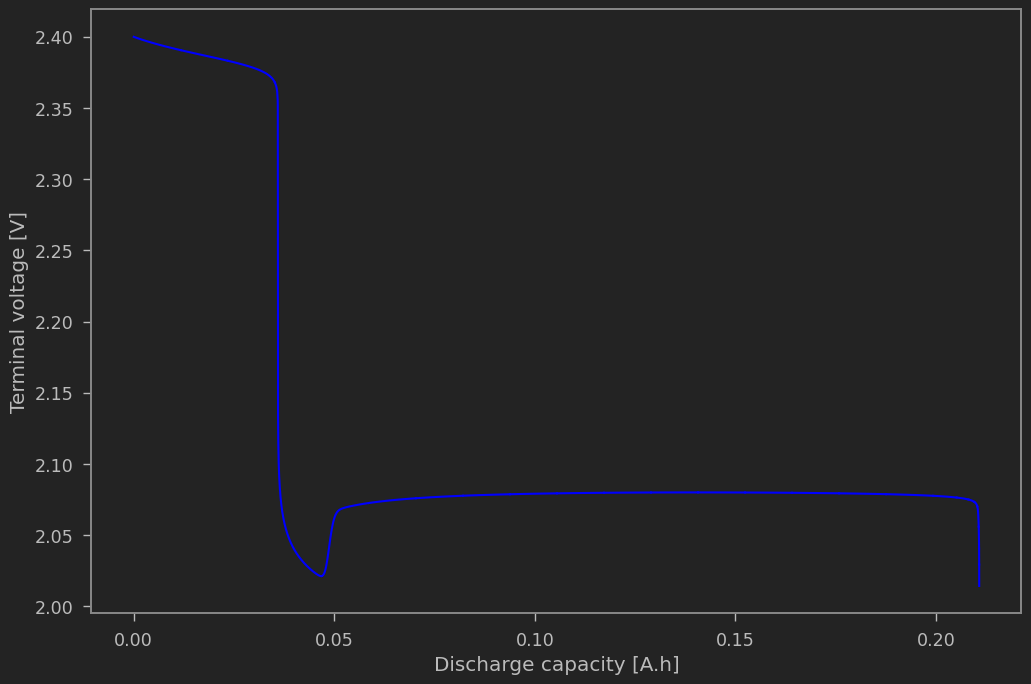

In [91]:
plot_full_sim(sim_data, 'Discharge capacity [A.h]', 'Terminal voltage [V]')

# Basic Simulation with Concentration Effects

In [92]:
def run_partial_sim(interval, current, initial_conditions):
    
    S8_initial, S6_initial, S4_initial, S2_initial, S_initial, Sp_initial, V_initial = initial_conditions
    
    # initialize model
    model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
    params = model.default_parameter_values
    params.update(
        {
            "Current function [A]": current,
            "Initial Condition for S8 ion [g]": S8_initial,#*1.1,
            "Initial Condition for S6 ion [g]": S6_initial,#*0.00025,
            "Initial Condition for S4 ion [g]": S4_initial,#*0.6,
            "Initial Condition for S2 ion [g]": S2_initial,#*0.05,
            "Initial Condition for S ion [g]": S_initial,
            "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
            "Initial Condition for Terminal Voltage [V]": V_initial,
            #"Precipitation rate [s-1]": 50,
            "Shuttle rate coefficient during discharge [s-1]": 0.0002,
            "Lower voltage cut-off [V]": 1.8,
            "Standard Potential L [V]": 1.95,
            "Standard Potential M [V]": 1.975,
            "Standard Potential H [V]": 2.38,
            "gamma": 200,
            "kappa" : 30,
            #"S saturation mass [g]": 1e-6,
            #"Electrolyte volume per cell [L]": 0.0114*.25
        }
    )
    
    # run simulation 
    sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        #max_step_decrease_count = 15
            ),
        )
    sim.solve(np.linspace(0, interval, 100))
    
    return sim

def run_full_sim(total_time_in_seconds, current, initial_conditions):
    interval = 1000
    sim_data = []
    total_sim_time = 0
    
    while total_sim_time < total_time_in_seconds:
        print('\n\n\n\n')
        print(total_sim_time)
        print('\n\n\n\n')
        try:
            
            sim = run_partial_sim(interval, current, initial_conditions)
            sim_data.append(sim)
            initial_conditions = (sim.solution["S8 [g]"].entries[-1],
                sim.solution["S6 [g]"].entries[-1],
                sim.solution["S4 [g]"].entries[-1],
                sim.solution["S2 [g]"].entries[-1],
                sim.solution["S [g]"].entries[-1],
                sim.solution["Precipitated Sulfur [g]"].entries[-1],
                sim.solution["Terminal voltage [V]"].entries[-1])
            total_sim_time += interval
        except:
            if interval > 1:
                interval /= 2
            else:
                break
    return sim_data

def plot_full_sim(sim_data, x_var, y_var):
    x_shift = 0
    for sim in sim_data:
        plt.plot(sim.solution[x_var].entries + x_shift, sim.solution[y_var].entries, color = 'blue')
        x_shift += sim.solution[x_var].entries[-1]
    plt.xlabel(x_var)
    plt.ylabel(y_var)

In [93]:
initial_conditions = S8_initial, S6_initial, S4_initial, S2_initial, S_initial, Sp_initial, V_initial
sim_data = run_full_sim(18000, 0.0422, initial_conditions)






0










1000










2000










3000







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






4000










5000










6000










7000










8000










9000










10000










11000










12000










13000










14000







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c






15000










16000










17000







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

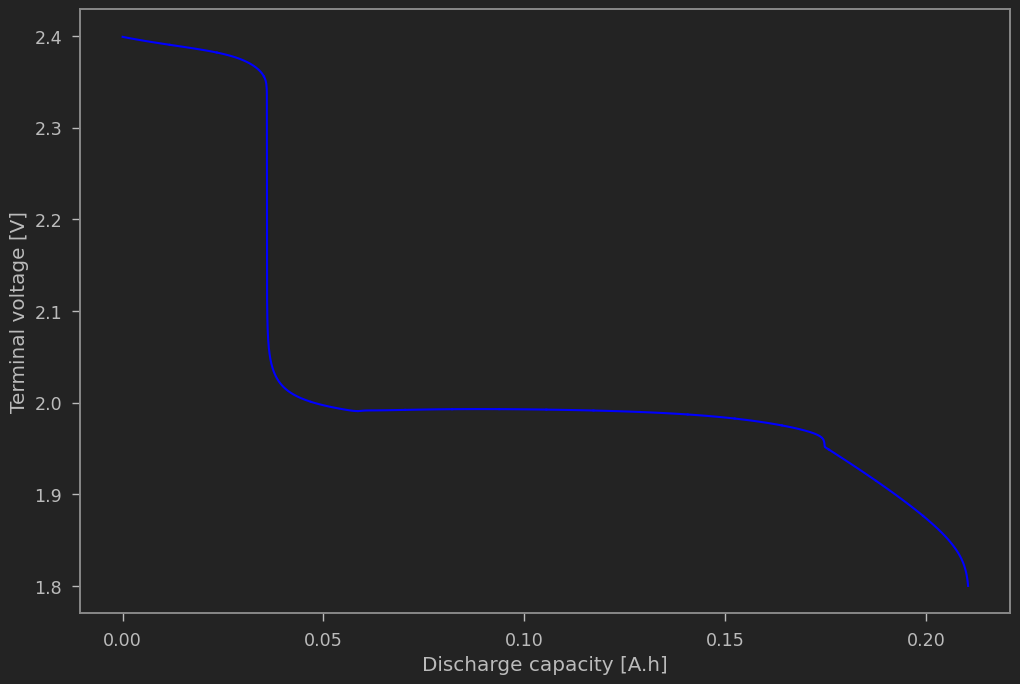

In [94]:
plot_full_sim(sim_data, 'Discharge capacity [A.h]', 'Terminal voltage [V]')

In [95]:
# Set up and solve simulation
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, mode="fast", extra_options_setup={"max_step_size": 0.1},
    ),
)
# step up to tf in steps of ts
tf = 7000
ts = 1000
t = 0
max_count = 10
count = 0
# take a small initial 60s step 
sim.step(60)
t = sim.solution.t[-1]
while t < tf:
    try:
        sim.step(ts,npts=int(ts/10))
    except (RuntimeError,pybamm.SolverError):
        count = count + 1
        ts = ts / 2 
    t = sim.solution.t[-1]

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

IndexError: index 0 is out of bounds for axis 0 with size 0

In [10]:
model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": S8_initial,#*1.1,
        "Initial Condition for S6 ion [g]": S6_initial,#*0.00025,
        "Initial Condition for S4 ion [g]": S4_initial,#*0.6,
        "Initial Condition for S2 ion [g]": S2_initial,#*0.05,
        "Initial Condition for S ion [g]": S_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        #"Precipitation rate [s-1]": 50,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 1.8,
        "Standard Potential L [V]": 1.95,
        "Standard Potential M [V]": 1.975,
        "Standard Potential H [V]": 2.38,
        "gamma": 200,
        "kappa" : 30,
        #"S saturation mass [g]": 1e-6,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)

In [73]:
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        max_step_decrease_count = 15
    ),
)
time_in_seconds = 15000
sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds/10)))
notify

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

KeyboardInterrupt: 

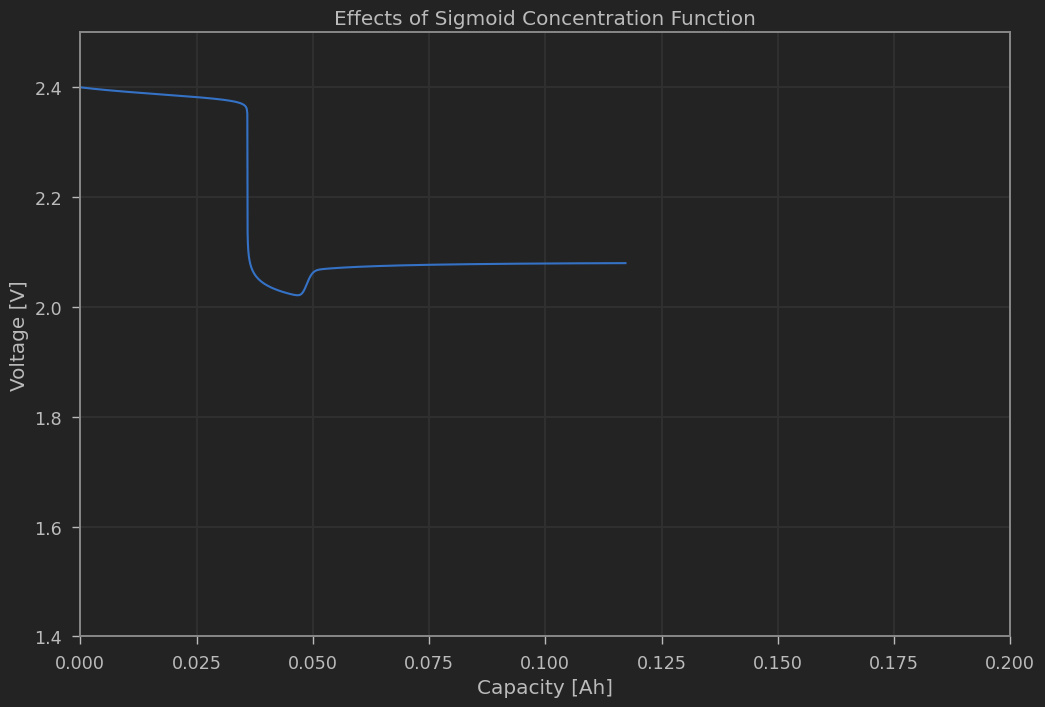

In [9]:
voltage = sim.solution['Terminal voltage [V]'].entries 
capacity = sim.solution["Discharge capacity [A.h]"].entries
plt.plot(capacity, voltage)
plt.ylim([1.4,2.5])
plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Effects of Sigmoid Concentration Function')
#plt.legend(['Sigmoid Function', 'Experiment'])
plt.grid(True)

In [ ]:
model = pybamm.lithium_sulfur.ZeroD_Chemistry_5()

experiment = pybamm.Experiment(
    [
        (
            "Discharge at 0.0422 A until 2.35 V"
        ),
    ],
)
params = model.default_parameter_values
params.update(
    {
        #"Current function [A]": current,
        "Initial Condition for S8 ion [g]": discharge_initial_data[1],
        "Initial Condition for S6 ion [g]": discharge_initial_data[2],
        "Initial Condition for S4 ion [g]": discharge_initial_data[3],
        "Initial Condition for S2 ion [g]": discharge_initial_data[4],
        "Initial Condition for S ion [g]": discharge_initial_data[5],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[6],
        "Initial Condition for Terminal Voltage [V]": 2.41,#V_initial,
        #"Precipitation rate [s-1]": 50,
        #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 2.2,
        "Standard Potential L [V]": 2.0,
        "Standard Potential M [V]": 2.0,
        "Standard Potential H [V]": 2.38,
        "gamma": 0,#25000,
        "kappa" : 0#,15,
        #"S saturation mass [g]": 1e-6,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)

sim = pybamm.Simulation(
    model,
    parameter_values=params,
    experiment=experiment,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-3,
        dt_max = 10,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
time_in_seconds = 1000
sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds/10)))
notify

In [ ]:
voltage = sim.solution['Terminal voltage [V]'].entries 
capacity = sim.solution["Discharge capacity [A.h]"].entries
plt.plot(capacity, voltage)

In [ ]:
pybamm.CasadiSolver?

In [ ]:
sim.solve?